# Lab 6 - **Classification Performance Metrics**

*Note: The content of this notebook has been adapted from [Geron's chapter 3 notebook](https://github.com/ageron/handson-ml3/blob/main/03_classification.ipynb) in compliance with the [Apache v2 License](https://github.com/ageron/handson-ml3/blob/main/LICENSE).*

The dataset employed in this assignment is the [MNIST Database](https://en.wikipedia.org/wiki/MNIST_database), a large collection of handwritten digits commonly utilized for training diverse image processing systems. This database is widely employed for both training and testing within the realm of machine learning. Its development involved remixing samples from NIST's original datasets.

Now let's load all the libraries which we use in this notebook:

In [60]:
import numpy as np
import pandas as pd

# plotting modules
from matplotlib import pyplot as plt
import matplotlib.patches as patches  # for curved arrows
import seaborn as sns

# The web source of the MNIST dataset that we will work with
from sklearn.datasets import fetch_openml

# Preprocessing 
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import scale

# The classifiers we will use in this notebook
from sklearn.svm import SVC

# Train test split
from sklearn.model_selection import train_test_split

# performance metrics
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import precision_score, recall_score


## Obtain the data 

The data is fetched from ***openml.org***. [openml.org](https://openml.org/), a public repository for machine learning data and experiments. It allows users to upload open datasets. The ***sklearn.datasets*** package can download datasets from this repository using the ***sklearn.datasets.fetch_openml*** ([sklearn User Guide](https://scikit-learn.org/stable/datasets/loading_other_datasets.html#openml), [sklearn docs](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_openml.html)). The website contains a variety of datasets, tasks, benchmarks, and other machine learning evaluations. Users can search across the collections and access documentation explaining the process. The landing page also provides code snippets demonstrating how to use the datasets in Python and R.

The dataset description, available in the [Wikipedia article](https://en.wikipedia.org/wiki/MNIST_database), indicates that the dataset comprises 60,000 training images and 10,000 testing images, created by re-mixing samples from NIST's original datasets. Additionally, the black and white images from NIST were normalized to fit into a 28x28 pixel bounding box and anti-aliased, which introduced grayscale levels. The Sample images from MNIST test dataset show 10 unique digits ranging from 0 to 9.

In [61]:
mnist = fetch_openml('mnist_784', as_frame=False, parser='auto')

The *mnist_784* consists of 70,000 grayscale images of handwritten digits, split into 60,000 training images and 10,000 test images. Each image is 28x28 pixels, and hence the input dimension is 784 (28 x 28).

## Exploring the Data

The mnist object returned by the ***fetch_openml*** function is a ***Bunch*** object ([docs](https://scikit-learn.org/stable/modules/generated/sklearn.utils.Bunch.html)), which is a typical sklearn object employed for storing datasets.

In [62]:
type(mnist)

sklearn.utils._bunch.Bunch

It is analogous to a dictionary object, with keys and values similar to those of a standard Python dictionary. Therefore, we can display all of its keys by printing them out:

In [63]:
list(mnist)

['data',
 'target',
 'frame',
 'categories',
 'feature_names',
 'target_names',
 'DESCR',
 'details',
 'url']

there is another way to archieve the same:

In [64]:
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

The object also includes a description of the dataset it holds, provided by the dataset's curators. This description can be accessed using the ***DESCR*** method of the object.

In [65]:
print(mnist.DESCR)

**Author**: Yann LeCun, Corinna Cortes, Christopher J.C. Burges  
**Source**: [MNIST Website](http://yann.lecun.com/exdb/mnist/) - Date unknown  
**Please cite**:  

The MNIST database of handwritten digits with 784 features, raw data available at: http://yann.lecun.com/exdb/mnist/. It can be split in a training set of the first 60,000 examples, and a test set of 10,000 examples  

It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image. It is a good database for people who want to try learning techniques and pattern recognition methods on real-world data while spending minimal efforts on preprocessing and formatting. The original black and white (bilevel) images from NIST were size normalized to fit in a 20x20 pixel box while preserving their aspect ratio. The resulting images contain grey levels as a result of the anti-aliasing technique used by the normalization algorithm. the images were centered in a 28x28 image b

Now let's have a look into the ***data*** and the ***target*** attributes.

In [66]:
mnist.data.shape

(70000, 784)

In [67]:
mnist.target.shape

(70000,)

In [68]:
print(mnist.target[0], mnist.target[1], mnist.target[2])

5 0 4


In [69]:
print(mnist.target[0], mnist.target[1], mnist.target[2])

5 0 4


The "70000" in the shape denotes the number of rows in the dataset, while the "784" indicates the number of columns, each representing a pixel. The ***target*** values correspond to the original ***digit*** that the entire row represents.

In [70]:
mnist.data[0,200:205]

array([  0,   0,   0,  49, 238], dtype=int64)

The values 0, 49, and 238 denote the pixel values based on the color each pixel is filled with. All 784 pixels collectively represent the entire image of the digit.

We'll rename these objects using our standard naming conventions, which are commonly used regardless of the specific dataset under study.

In [71]:
X = mnist.data
y = mnist.target.astype(int)

At this point, it would be beneficial to examine an actual data instance, specifically a single image.

In [72]:
def plot_digit(image_data):
    img = image_data.reshape(28, 28)
    plt.imshow(img, cmap="binary")
    plt.axis("off")

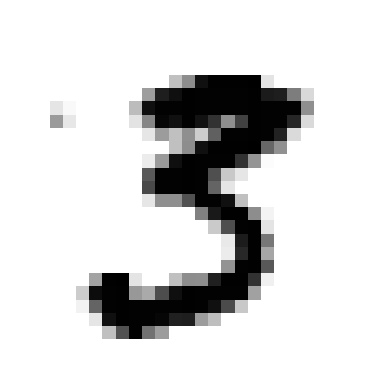

In [73]:
some_digit = X[49]  # We are using the 50th image in dataset here.
plot_digit(some_digit)
plt.show()

Based on the displayed image, it appears to resemble a **3**. Now, let's determine the target value associated with this image. The target value is what our model should predict to yield the correct result.

In [74]:
y[49]  # Label for first image

3

As anticipated, the target value for the 50th image in the dataset is 3. To enhance our familiarity with the dataset, let's visualize the first 100 images.

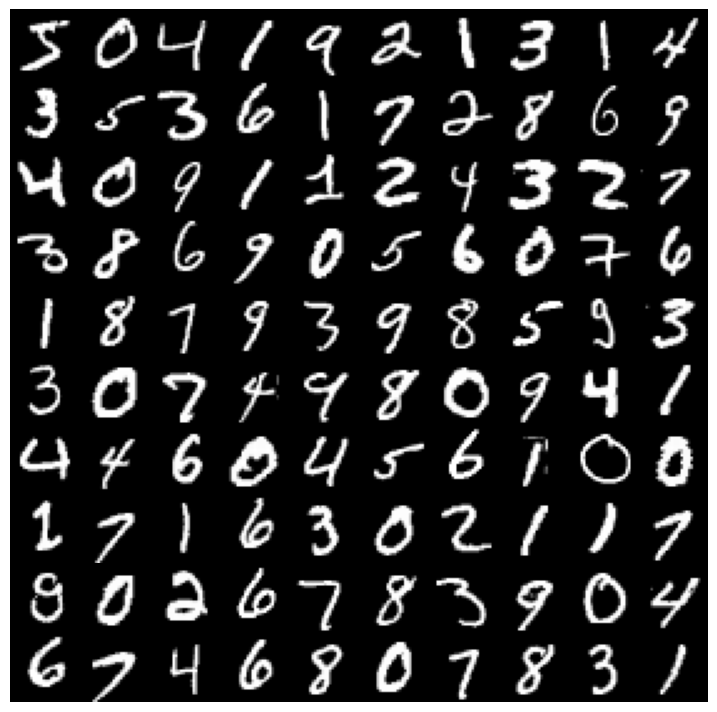

In [75]:
plt.figure(figsize=(9, 9))
for idx, image_data in enumerate(mnist['data'][:100]):
    plt.subplot(10, 10, idx + 1)
    plt.imshow(image_data.reshape(28, 28), cmap="gray")
    plt.axis("off")
plt.subplots_adjust(wspace=0, hspace=0)
plt.show()

This allows for an initial acquaintance with the dataset.

A critical characteristic of a classification dataset is its skewness ([Wikipedia](https://en.wikipedia.org/wiki/Skewness)). In the context of classification tasks, skewness refers to the uniformity of the data in relation to the distribution of samples per label, in this case, the number of images for each digit. A perfectly uniform distribution, where each class has an equal number of images, would result in a dataset with 0 skewness.

In [76]:
from collections import Counter

# To count number of samples per label
label_counts = Counter(y)

# To print the number of samples per label
for label, count in label_counts.items():
    print(f"Label {label}: {count} samples")

Label 5: 6313 samples
Label 0: 6903 samples
Label 4: 6824 samples
Label 1: 7877 samples
Label 9: 6958 samples
Label 2: 6990 samples
Label 3: 7141 samples
Label 6: 6876 samples
Label 7: 7293 samples
Label 8: 6825 samples


The statistics detailing the distribution of images for each digit, as indicated by the target values, are provided above. With nearly 7000 samples for each digit out of the 70000 images, the distribution of samples appears to be relatively balanced with minimal skewness.

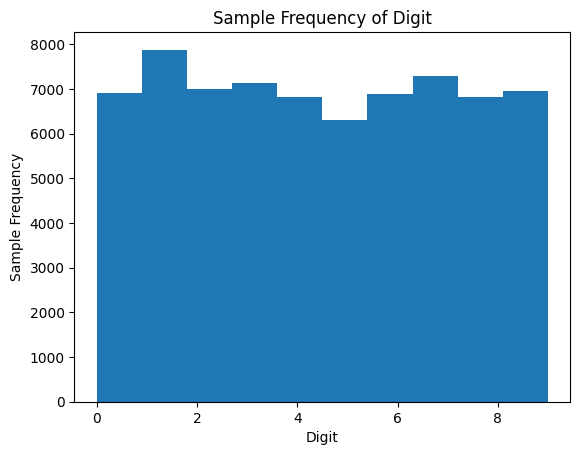

In [77]:
plt.hist(y)
plt.xlabel('Digit')
plt.ylabel('Sample Frequency')
plt.title('Sample Frequency of Digit')
plt.show()

The histogram illustrates that, aside from the digit 1, samples for all other digits are uniformly distributed.

## Class selection

We choose to have all the classes. 

## Train Test Split

Now that we have gained familiarity with the data, we can proceed with preprocessing it by partitioning it into training and validation datasets. Preprocessing may involve augmenting the data, scaling it, removing outliers, among other techniques. In this case, we will simply divide the data into a training and test set, and create a new set of labels to transform the classification into a binary outcome, as opposed to ten-fold.

The data will be split with 20% allocated for testing and 20% for validation, leaving the remaining 80% for training purposes.

In [78]:
X_scaled = scale(X)
X_tr, X_temp, y_tr, y_temp = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_va, X_test, y_va, y_test = train_test_split(X_temp, y_temp, test_size=0.4, random_state=42)

## Train Model

In this instance, we are employing the Support Vector Machines ([docs](https://scikit-learn.org/stable/modules/svm.html)) for classification purposes. This class is proficient in conducting both binary and multi-class classification on a dataset. It encompasses slightly different sets of parameters and distinct mathematical formulations.

The model reference was sourced from this [kaggle code](https://www.kaggle.com/code/nishan192/mnist-digit-recognition-using-svm).

In [79]:
svc_model = SVC(kernel='linear')
svc_model.fit(X_tr, y_tr)

SVC(kernel='linear')

## Evaluate the Model

First, we will assess the model using the validation set, and then we will proceed to determine the accuracy, confusion matrix, precision, recall, and F1 score for each class.

In [80]:
y_va_pred = svc_model.predict(X_va)

### **Accuracy**

Let's begin with discussing the use of ***accuracy*** as a performance metric. Within the ***sklearn*** library, a performance metric is referred to as a ***scoring metric***, and its value is denoted as the ***score***.

The concept of accuracy can be understood as the ratio of correct predictions to all predictions([Wikipedia](https://en.wikipedia.org/wiki/Accuracy_and_precision#In_binary_classification)), as defined by the formula:

$accuracy = \frac{correct\ classifications}{all\ classifications}$

In our scenario, the accuracy is computed over the test set for each of the cross-validation folds. It's worth noting that like other performance metrics, accuracy can be calculated on any portion of the complete dataset, including the training set. Therefore, when reporting the accuracy value, it's essential to specify the part of the dataset on which it was calculated.

Additional resources related to accuracy in sklearn are here for further exploration:
https://scikit-learn.org/stable/modules/model_evaluation.html#accuracy-score

https://stackoverflow.com/questions/65155034/what-do-i-need-to-do-to-increase-model-accuracy-in-sklearn 

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html

https://www.analyticsvidhya.com/blog/2015/12/improve-machine-learning-results/

https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values

In [81]:
accuracy = accuracy_score(y_va, y_va_pred)
print(accuracy)

0.9211904761904762


The model's accuracy stands at 92.1%; however, this is not an optimal accuracy as a dummy classifier can achieve 90% accuracy.

## Confusion Matrix

To comprehend the concept of a confusion matrix, let's consider a specific example. In a binary classification scenario, there are 4 potential outcomes for a single prediction of a sample concerning the target label (5 in this instance). The target label is chosen from two labels based on our interest and the primary objective of the classifier.

In binary classification, the positive class refers to one of the two classes, and it denotes the class the model aims to predict. The designation of which class is considered positive or negative is often arbitrary and is determined by the context of the problem. For instance, in a medical test for a disease, the positive class might be "disease present," with the negative class being "disease not present."

There are two categories of correct predictions:

True Positive (TP): The prediction corresponds to the target class, and this is accurate in accordance with the ground truth.
True Negative (TN): The prediction does not correspond to the target class, and this is accurate.
Similarly, there are two types of incorrect predictions:

False Positive (FP): The prediction corresponds to the target class, but this is incorrect according to the ground truth.
False Negative (FN): The prediction does not correspond to the target class, and this is incorrect.
The confusion matrix is a tabular representation where:

Each row signifies an actual label, with one row assigned to each label in the dataset.
Each column signifies a predicted label, with one column assigned to each label in the dataset.
Each cell in the table calculates the count of samples in the dataset that exhibits a specific predicted-actual combination. This count can be expressed as a percentage by dividing it by the total number of samples in the dataset.

Resources to confusion metric:

https://scikit-learn.org/stable/modules/model_evaluation.html#confusion-matrix

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html


In [82]:
con_matrix = confusion_matrix(y_va, y_va_pred)
print(con_matrix)

[[775   1   2   0   2   7   7   1   2   2]
 [  0 929   2   4   1   2   0   3   5   2]
 [  5   7 747   9  10   6   7   7  12   2]
 [  2   3  29 763   0  26   1   4  10   8]
 [  5   1   6   2 717   3   4   3   1  28]
 [  6   1   8  27   4 691  13   1  13   5]
 [  8   1  20   0  12  21 783   0   1   0]
 [  1   3  11   7  20   3   0 879   1  12]
 [  8  16  15  39   2  28   6   5 717  11]
 [  2   4   4  11  34   5   0  23   6 737]]


## Precision, Recall and F1 for each class

### Precision and Recall

In classification, precision and recall serve as additional performance metrics ([Wikipedia](https://en.wikipedia.org/wiki/Precision_and_recall)). They are computed and presented in relation to the 'class of interest', which could be any class for which precision and recall are to be calculated. The selection of this class hinges on the predefined success criteria for the model. For example, in a scenario where the model is designed to identify the risk of an illness based on medical test results, the class of interest would likely be the existence of the medical condition. This class of interest is referred to as the "positive class."

- Precision is the ratio of the number of correctly labeled positive samples to all samples labeled as positive. It indicates the model's accuracy in predicting the positive class and is calculated as: (Precision = \frac{True \ Positives}{True \ Positives + False \ Positives}). Precision is often defined as 'the fraction of relevant instances among the retrieved instances', making it analogous to the concept of relevance in search results, such as those in Google.

- Recall (also known as sensitivity) represents the number of correctly labeled positive samples out of all positive samples in the test dataset and is calculated as: (Recall = \frac{True \ Positives}{True \ Positives + False \ Negatives}). It signifies the model's ability to identify samples of the 'class of interest,' essentially indicating how many relevant instances it is able to recall.

- It's worth noting that precision and recall can be calculated for multiple classes without any complications. The precision and recall image provided in Wikipedia effectively illustrates these definitions.

See also [SKLearn User Guide](https://scikit-learn.org/stable/modules/model_evaluation.html#precision-recall-f-measure-metrics)

### F1-score

Comparing classifiers using a single encompassing performance metric can be beneficial, and the F1-score is a commonly used metric for this purpose.

The F1 score is derived from the precision and recall of the test. It represents the harmonic mean of precision and recall(harmonic mean is the average of rates ([Wikipedia](https://en.wikipedia.org/wiki/Harmonic_mean)), see more below), with a value ranging from 0 to 1. A score of 1.0 indicates perfect precision and recall, while a score of 0 suggests that either precision or recall is zero([Wikipedia](https://en.wikipedia.org/wiki/F-score)). The harmonic mean, unlike the arithmetic mean, assigns more weight to low values. Consequently, a classifier will only achieve a high F1 score if both precision and recall are high.

The F1 score is calculated using the formula:

$F1-score = \frac{2}{\frac{1}{precision} + \frac{1}{recall}} = 2 \cdot \frac{precision \cdot recall}{precision + recall} = \frac{TP}{TP + \frac{FP+FN}{2}}$

It is important to note that the F1 score is independent of True Negatives (TN).

Calculating precision and recall for chosen 5 classes:

In [83]:
classif_report = classification_report(y_va, y_va_pred, digits=4)
print(classif_report)

              precision    recall  f1-score   support

           0     0.9544    0.9700    0.9621       799
           1     0.9617    0.9800    0.9707       948
           2     0.8851    0.9200    0.9022       812
           3     0.8852    0.9019    0.8934       846
           4     0.8940    0.9312    0.9122       770
           5     0.8725    0.8986    0.8853       769
           6     0.9537    0.9255    0.9394       846
           7     0.9492    0.9381    0.9436       937
           8     0.9336    0.8465    0.8879       847
           9     0.9133    0.8923    0.9026       826

    accuracy                         0.9212      8400
   macro avg     0.9203    0.9204    0.9200      8400
weighted avg     0.9217    0.9212    0.9211      8400



## Precision Recall Curve For Single Class

In Scikit-learn, the ***decision_function*** method is available for certain classifiers, such as SVMs and logistic regression models. This method **returns the "distance" of each data point to the decision boundary of the classifier.**

For binary classification, the ***decision boundary*** is represented by a hyperplane that separates the two classes. When used, the decision_function method provides the signed distance of each data point to this hyperplane. The sign of the distance indicates the side of the hyperplane on which the data point is located, while the magnitude of the distance denotes how far the data point is from the hyperplane.

For instance, if the ***decision_function*** method returns a value of 2 for a specific data point, it signifies that the data point is situated on the positive side of the decision boundary and is positioned 2 units away from the boundary. Conversely, if the method returns a value of -1 for another data point, this indicates that the data point resides on the negative side of the decision boundary and is positioned 1 unit away from the boundary.

The ***decision_function*** method is valuable for assessing the confidence of the classifier's predictions. Data points with larger absolute values of the decision function are situated further from the decision boundary and are more confidently classified than those with smaller absolute values.

SKLearn's [precision_recall_curve](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.precision_recall_curve.html) function computes precision-recall pairs for various probability thresholds. 
- It's important to note that this implementation is confined to the binary classification task.
- The initial precision and recall values are precision=class balance and recall=1.0, corresponding to a classifier that always predicts the positive class. 
- The final precision and recall values are 1.0 and 0.0, respectively, without a corresponding threshold, ensuring that the graph begins on the y-axis.

In [84]:
target_class = 3
y_va_binary = (y_va == target_class).astype(int)
y_va_scores = svc_model.decision_function(X_va)
precision, recall, thresholds = precision_recall_curve(y_va_binary, y_va_scores[:, target_class])

In [85]:
print(precision.shape)
print(recall.shape)
print(thresholds.shape)

(8401,)
(8401,)
(8400,)


Let's take a look at the precision, recall, and threshold values.

In [86]:
print(precision)
print(recall)
print(thresholds)

[0.10071429 0.10072628 0.10073827 ... 1.         1.         1.        ]
[1.         1.         1.         ... 0.00236407 0.00118203 0.        ]
[-0.3312696  -0.33101897 -0.33076224 ...  9.33131982  9.33140654
  9.33147298]


The threshold spans from -0.3 to 9.4. Let's focus on a threshold within this range.

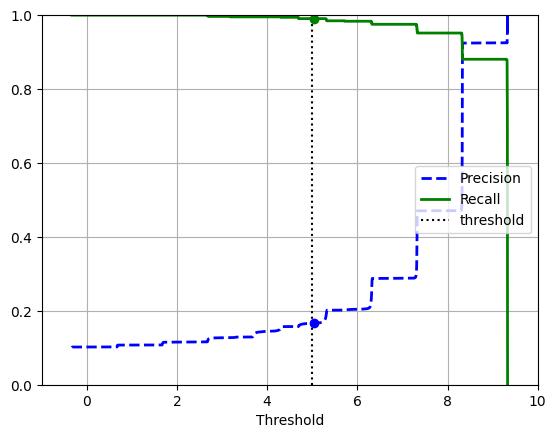

In [87]:
threshold = 5
plt.plot(thresholds, precision[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recall[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")
idx = (thresholds >= threshold).argmax()  # first index ≥ threshold
plt.plot(thresholds[idx], precision[idx], "bo")
plt.plot(thresholds[idx], recall[idx], "go")
plt.axis([-1, 10, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")
plt.show()

Here, we utilize the same data to plot a Precision-Recall curve, which is an effective tool for selecting a threshold.

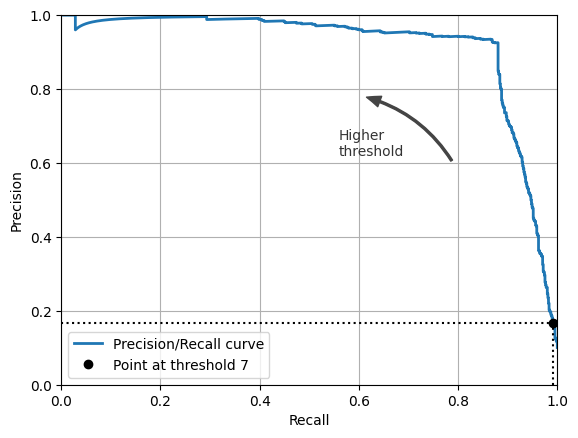

In [88]:
plt.plot(recall, precision, linewidth=2, label="Precision/Recall curve")
plt.plot([recall[idx], recall[idx]], [0., precision[idx]], "k:")
plt.plot([0.0, recall[idx]], [precision[idx], precision[idx]], "k:")
plt.plot([recall[idx]], [precision[idx]], "ko",
         label="Point at threshold 7")
plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))
plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")
plt.show()

Upon review, it's evident that the threshold value yields low precision but higher recall. To enhance precision, increasing the threshold value is recommended.

## Without retraining increase the precision 

### Precision/Recall Tradeoff and the Decision Threshold

With a trained classifier and without retraining, it is feasible to enhance either the precision or the recall at the expense of the other. This phenomenon is termed the precision/recall tradeoff (note that a distinct classifier could theoretically improve both metrics). It's important to note that the tradeoff is pertinent solely to a specific classifier with a defined set of parameters.

In this context, we will adjust the decision threshold of our binary classifier, which will consequently alter its precision and recall without necessitating additional training.

Let's find the threshold for a 90% precision:

In [89]:
thres_90_prec = thresholds[np.argmax(precision >= 0.90)]

print("Threshold for 90% precision:", thres_90_prec)

Threshold for 90% precision: 8.330360537903912


To validate, we can now make predictions based on the classifier's scores and the new thresholds, and subsequently recalculate the precision.

In [90]:
y_va_pred_90 = (y_va_scores >= thres_90_prec)

In [91]:
precision_score(y_va_binary, y_va_pred_90[:,target_class])

0.9008464328899637

And here is the recall corresponding to that threshold:

In [92]:
recall_90_prec = recall_score(y_va_binary, y_va_pred_90[:, target_class])
recall_90_prec

0.8806146572104019

This threshold value provides higher precision without significantly compromising recall. Therefore, we will opt for this threshold value to achieve higher precision. However, to further increase the recall beyond 0.875, we will need to explore lower threshold values.

## Run Test Set

In [93]:
y_test_pred = svc_model.predict(X_test)
test_acc = accuracy_score(y_test, y_test_pred)
test_con_matrix = confusion_matrix(y_test, y_test_pred)
test_classif_report = classification_report(y_test, y_test_pred)

### Accuracy:

In [94]:
print("Test Accuracy:", test_acc)

Test Accuracy: 0.9201785714285714


### Confusion Matrix

In [95]:
print("Test Confusion Matrix:\n", test_con_matrix)

Test Confusion Matrix:
 [[524   0   2   1   1   7   3   1   5   0]
 [  0 634   3   3   0   1   0   2   7   2]
 [  3   6 522  13   6   2   3   0  10   3]
 [  1   0   7 539   3  21   0   5   9   2]
 [  0   2   9   0 497   1   1   3   2  10]
 [  7   9   4  25   5 433   8   0   7   6]
 [  3   2   9   2   5  10 517   1   1   0]
 [  0   3  13   6   3   4   0 525   1  11]
 [  7  10  11  15   4  16   4   5 435   3]
 [  5   7   6   7  17   3   0  17   5 527]]


### Report

In [96]:
print("Test Classification Report:\n", test_classif_report)

Test Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.96      0.96       544
           1       0.94      0.97      0.96       652
           2       0.89      0.92      0.90       568
           3       0.88      0.92      0.90       587
           4       0.92      0.95      0.93       525
           5       0.87      0.86      0.86       504
           6       0.96      0.94      0.95       550
           7       0.94      0.93      0.93       566
           8       0.90      0.85      0.88       510
           9       0.93      0.89      0.91       594

    accuracy                           0.92      5600
   macro avg       0.92      0.92      0.92      5600
weighted avg       0.92      0.92      0.92      5600



The model accurately predicts values with 91% accuracy for the test set. Additionally, it achieves an average precision, recall, and f1-score of 0.92. While the model's performance is commendable, it may not be the best.